/home/lerato/phishing-risk-detection-project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


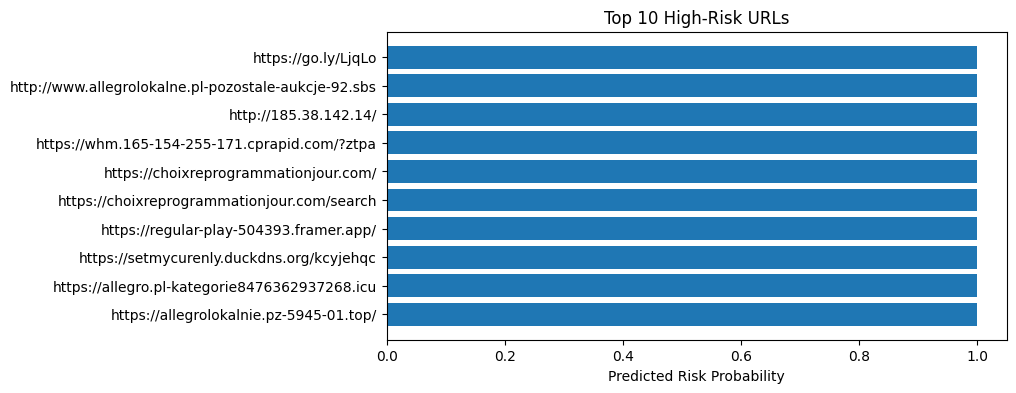

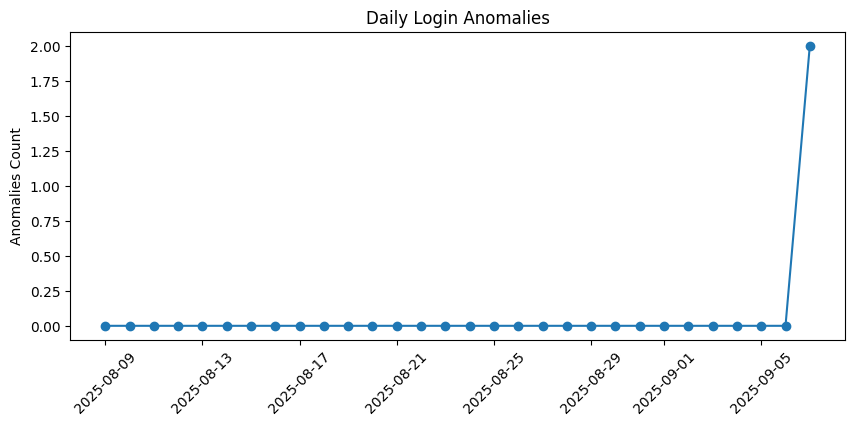

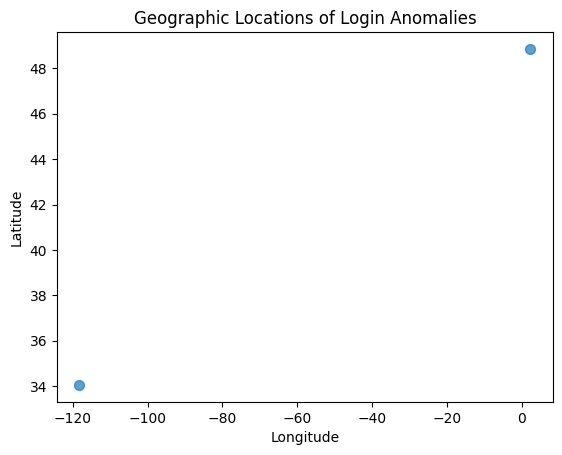

In [1]:
# 06-dashboard-ideas.ipynb
# Dashboard & Reporting Ideas for SOC Analysts

"""
## 06 - Dashboard Concepts

This notebook sketches prototype visualizations and reporting for Security Operations Center analysts using our models:

1. Load phishing detection model, features, and SHAP values.
2. Load auth risk model and synthetic logs.
3. Create key Plots:
   - Top risky URLs (by RF probability)
   - SHAP feature importance bar chart
   - Time-series of login risk events
   - Geographic map of anomalies (scatter)
4. Outline a mock dashboard layout using matplotlib/subplots.
"""

#%%
# 1. Imports and Data
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# joblib is a standalone package now; import directly
import joblib
import shap

# Paths
PHISH_FEATURES = os.path.join('..','data','processed','phishing_graph_features.csv')
PHISH_MODEL = os.path.join('..','models','phishing_rf_model.pkl')
SHAP_VALUES = os.path.join('..','models','phishing_shap_summary.png')
AUTH_LOGS = os.path.join('..','data','processed','auth_logs.csv')
AUTH_MODEL = os.path.join('..','models','auth_risk_model.pkl')

#%%
# 2. Load data
phish_df = pd.read_csv(PHISH_FEATURES)
clf_phish = joblib.load(PHISH_MODEL)

auth_df = pd.read_csv(AUTH_LOGS)
clf_auth = joblib.load(AUTH_MODEL)

# 3. Top Risky URLs
# Prepare features used by the classifier (drop metadata/target columns)
features = phish_df.drop(['label','url','sender_domain','domain'], axis=1)

# Predict probabilities and handle the case where the classifier was trained with a single class
proba = clf_phish.predict_proba(features)

if proba.shape[1] == 1:
    # Only one class was seen during training. Infer which class it is.
    present_class = clf_phish.classes_[0]
    if present_class == 1 or str(present_class) == '1':
        risk_prob = np.ones(len(proba))
    else:
        risk_prob = np.zeros(len(proba))
else:
    # Binary (or multiclass) case: find index corresponding to the positive class label 1
    classes = list(clf_phish.classes_)
    if 1 in classes:
        pos_idx = classes.index(1)
    else:
        # Fallback: use the second column if class '1' not present (common binary ordering)
        pos_idx = 1
    risk_prob = proba[:, pos_idx]

phish_df['risk_prob'] = risk_prob
top_urls = phish_df.nlargest(10, 'risk_prob')[['url','risk_prob']]

plt.figure(figsize=(8,4))
plt.barh(top_urls['url'], top_urls['risk_prob'])
plt.xlabel('Predicted Risk Probability')
plt.title('Top 10 High-Risk URLs')
plt.gca().invert_yaxis()  # show highest at top
plt.show()
plt.show()

#%%
# 4. SHAP Feature Importance
# Use pre-generated SHAP summary image; display inline
from IPython.display import Image
Image(filename=SHAP_VALUES)

#%%
# 5. Login Risk Time Series
# Count anomalies per day
auth_df['date'] = pd.to_datetime(auth_df['time']).dt.date
daily_risk = auth_df.groupby('date')['anomaly'].sum().reset_index()

plt.figure(figsize=(10,4))
plt.plot(daily_risk['date'], daily_risk['anomaly'], marker='o')
plt.xticks(rotation=45)
plt.ylabel('Anomalies Count')
plt.title('Daily Login Anomalies')
plt.show()

#%%
# 6. Geo Scatter of Anomalies
anom = auth_df[auth_df['anomaly']==1]
plt.scatter(anom['lon'], anom['lat'], s=50, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Locations of Login Anomalies')
plt.show()

#%%
# 7. Mock Dashboard Layout Comments
# Use subplots or Dash/Streamlit for interactive UI
# - Top-left: Top risky URLs
# - Top-right: SHAP feature importance
# - Bottom-left: Time series of login anomalies
# - Bottom-right: Geo anomalies map
